In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_cols = ['diabetes_status_c_qc']

In [3]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [4]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [5]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

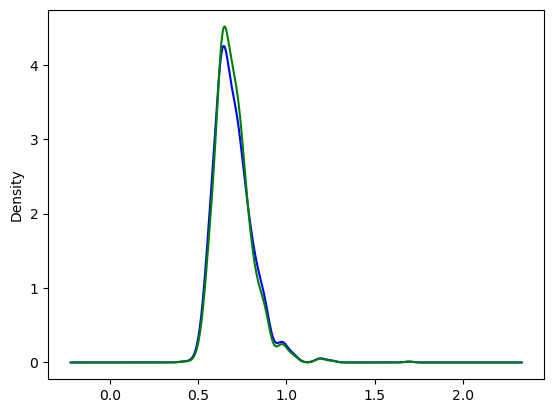

In [6]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [7]:
target_cols = ['diabetes_status_c_qc']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_col = 'diab'
# target = 'MorbidityCount'

# Specify the columns of interest
columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 

# defining the target column to be a column where the sum of the target values >= 2
# dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2 # *****CHECK********
dff[target_col] = (dff[target_cols] == 1) # *******CHECK**********


# New column
dff['MorbidityCount'] = dff[columns_of_interest].sum(axis=1) # *******CHECK**********

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()
dff['expectationPoisson'] = dff['MorbidityCount'].median()
# dff['expectation'].head()

# target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
treated[target_col] = (treated[target_cols] == 1).sum(axis = 1) == 1 # *******CHECK**********
treated['MorbidityCount'] = (treated[columns_of_interest] == 1).sum(axis = 1) # *******CHECK**********

# defining the expectations as mean of the target
treated['expectation'] = treated[target_col].mean()
treated['expectationPoisson'] = treated['MorbidityCount'].mean()

In [10]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', 'MorbidityCount','expectationPoisson',\
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [11]:
search_space

['bmi_c_qc',
 'age',
 'cimt_mean_max',
 'cholesterol_1_qc',
 'friedewald_ldl_c_c_qc',
 'hdl_qc',
 'triglycerides_qc',
 'waist_hip_r_c_qc',
 'waist_circumference_qc',
 'visceral_fat_qc',
 'subcutaneous_fat_qc',
 'sex',
 'hiv_final_status_c',
 'highest_level_of_education_qc',
 'partnership_status_c_qc',
 'ses_site_quintile_c_qc',
 'occupation_qc',
 'mvpa_cat_c',
 'alcohol_use_status_c_qc',
 'smoking_status_c_qc']

In [12]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser


In [ ]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [13]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [14]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [66]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_col].mean(), 3)
    positive_class_count = temp_df[target_col].sum()

    group_obs = temp_df[target_col].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 1.0: Subset = friedewald ldl c c qc[1.37 - 7.6] AND waist circumference qc[510.0 - 810.0] AND age[40.0 - 55.0] AND subcutaneous fat qc[0.25 - 4.28], 
LiteralsNumber = 4, 
Size = 262, Odds = 0.0, Score = 12.99
Penalty = 1.5: Subset = cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 - 21.35] AND mvpa cat c[1.0], 
LiteralsNumber = 3, 
Size = 197, Odds = 0.0, Score = 8.275
Penalty = 2: Subset = visceral fat qc[2.82 - 6.85] AND mvpa cat c[1.0] AND highest level of education qc[0.0 OR 2.0] AND waist hip r c qc[0.59 - 0.97], 
LiteralsNumber = 5, 
Size = 346, Odds = 0.0, Score = 12.437
Penalty = 2.5: Subset = mvpa cat c[1.0] AND waist circumference qc[510.0 - 780.0], 
LiteralsNumber = 2, 
Size = 259, Odds = 0.0, Score = 11.795


In [67]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,1.0,4,friedewald ldl c c qc[1.37 - 7.6] AND waist ci...,262,0.0,12.990
1,1.5,3,cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 -...,197,0.0,8.275
2,2.0,5,visceral fat qc[2.82 - 6.85] AND mvpa cat c[1....,346,0.0,12.437
3,2.5,2,mvpa cat c[1.0] AND waist circumference qc[510...,259,0.0,11.795


In [59]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,1.0,3,cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 -...,158,0.000,7.246
1,1.5,3,cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 -...,197,0.000,8.275
2,2.0,3,waist circumference qc[510.0 - 990.0] AND subc...,555,0.184,11.528
3,2.5,2,mvpa cat c[1.0] AND waist circumference qc[510...,259,0.000,11.795
